In [1]:
%pylab inline
import scipy.stats

from sigvisa.infer.correlations.proposal_signal_likelihood import likelihood_windowed, arbaseline, iidbaseline, preprocess_historical
from sigvisa.infer.correlations.weighted_event_posterior import build_ttr_model_array, atime_likelihood_to_origin_likelihood
#import seaborn as sns
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from sigvisa.experiments.aftershock_region import evids, stas
import cPickle as pickle

stas = ['ASAR', 'MKAR', 'CMAR', 'FITZ']

doublet = 5334939

evids = [5334501, 5334726, 5335822, 5349536, 
         5336237, 5335424, 5349441, 
         5336889, 5336015]

rs = EventRunSpec(evids=evids, stas=stas, runids=(1,), disable_conflict_checking=True)
ms = ModelSpec(template_model_type="param", wiggle_family="iid", 
               max_hz=10.0, inference_preset="openworld", raw_signals=True)
sg = rs.build_sg(ms)

with open("corr.sg", 'wb') as f:
    pickle.dump(sg, f)
    
#with open("corr.sg", 'rb') as f:
#    sg = pickle.load(f)

In [3]:
from sigvisa.source.event import get_event
ev = get_event(doublet)

646.756492467
(301,)


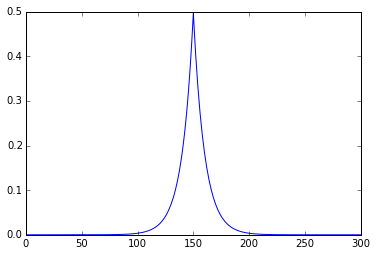

In [4]:
ttarray, tt_mean = build_ttr_model_array(sg, ev,"MK31", 10.0, K=150)
print tt_mean
print ttarray.shape
plot(ttarray)

In [13]:
from sigvisa.models.noise.noise_util import get_noise_model
from sigvisa.database.dataset import DET_TIME_COL
def extract_template(wave, atime, len_s):
    nm, nmid, _ = get_noise_model(waveform=wave, model_type="ar", order=0, return_details=True)
    sigma2_A = nm.em.std**2
    aidx = int((atime - wave['stime'])*wave['srate'])
    n = int(len_s * wave['srate'])
    A = wave.data[aidx:aidx+n]
    return A, sigma2_A
    
from sigvisa.signals.io import load_event_station_chan
def extract_template_from_leb(sta, evid, chan="auto", band="freq_2.0_4.5"):
    w =  load_event_station_chan(evid, sta, chan, evtype="leb")
    w = w.filter("%s;hz_10" % band)
    atime =  w['event_arrivals'][0,DET_TIME_COL]
    A, sigma2_A = extract_template(w, atime, 10)
    return A, sigma2_A

templates = []
for evid in evids:
    A, sigma2_A = extract_template_from_leb("MKAR", evid)
    tau = 0.99
    n = len(A)
    A = A.copy()
    alpha_hat = np.sqrt(np.dot(A, A)/n - sigma2_A)
    c = tau*alpha_hat/(alpha_hat**2+sigma2_A) * A
    kappa = 1- alpha_hat**2 * tau**2 / (alpha_hat**2 + sigma2_A)
    templates.append((evid, c, kappa))

1240230715.08 1240230925.08
1240238805.45 1240239015.45
1240241946.92 1240242164.7
1240249697.42 1240249907.42
1240257584.35 1240257794.35
1240265159.47 1240265369.47
1240266200.67 1240266410.67
1240276515.05 1240276725.05
1240288288.17 1240288498.17


In [14]:
s_new = load_event_station_chan(doublet, "MKAR", "auto", evtype="leb").filter("freq_2.0_4.5;hz_10")
nm, nmid, _ = get_noise_model(waveform=s_new, model_type="ar", order=0, return_details=True)
#sigma2_B = nm.em.std**2
sigma2_B = np.std(s_new.data)**2

1240246021.58 1240246231.58


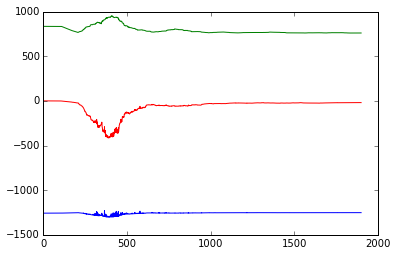

In [15]:
sdata = s_new.data
evid, c, kappa = templates[0]
wls = likelihood_windowed(sdata[:2000], c.data, kappa, sigma2_B)
ars, _ = arbaseline(sdata[:2000], len(c))
iids, _ = iidbaseline(sdata[:2000], len(c))
lls = wls + iids
plot(lls)
plot(ars)
plot(wls)


In [16]:
srate = s_new['srate']
ll_stime = s_new['stime']
print ll_stime

origin_ll, origin_stime = atime_likelihood_to_origin_likelihood(lls, ll_stime, srate, tt_mean, ttarray)


1240246001.58


TypeError: atime_likelihood_to_origin_likelihood() takes exactly 6 arguments (5 given)

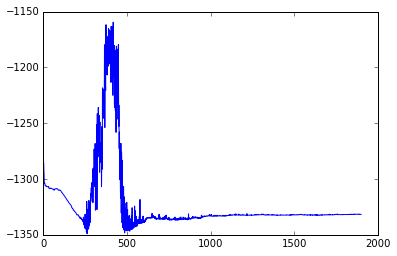

In [29]:
plot(lls)

1240246001.58 646.756492467 1240245339.82


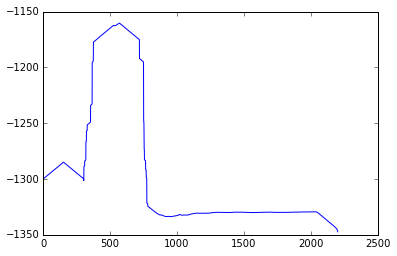

In [32]:
print ll_stime, tt_mean, origin_stime
plot(origin_ll)
#plot(np.exp(origin_ll-np.max(origin_ll)))

In [9]:
def likelihood_bc(sdata, c, tau):
    C = -1 + .5*np.log(2*np.pi)
    n = len(c)
    nA = np.linalg.norm(c)
    xc = my_xc(c, sdata)
    
    N = len(sdata)
    output = np.zeros((N-n,))
    for i in range(N-n):
        nB = np.linalg.norm(sdata[i:i+n])
        v = C + np.log( np.sqrt((1.0-xc[i]*xc[i])/n))
        output[i] = -n*v
    return output



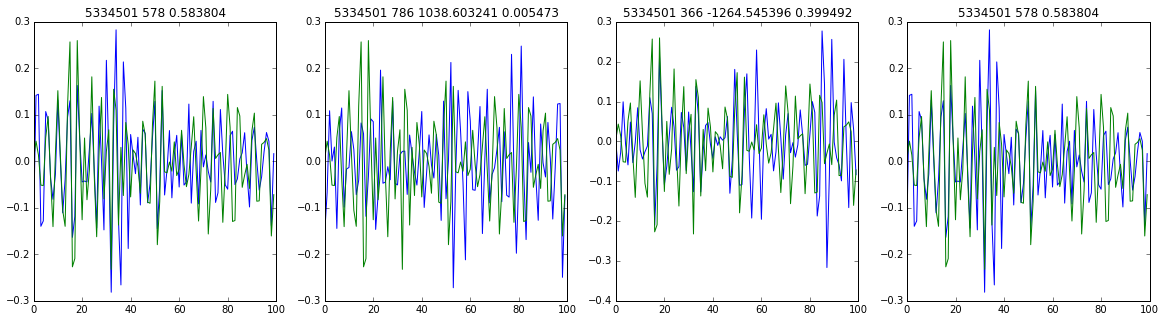

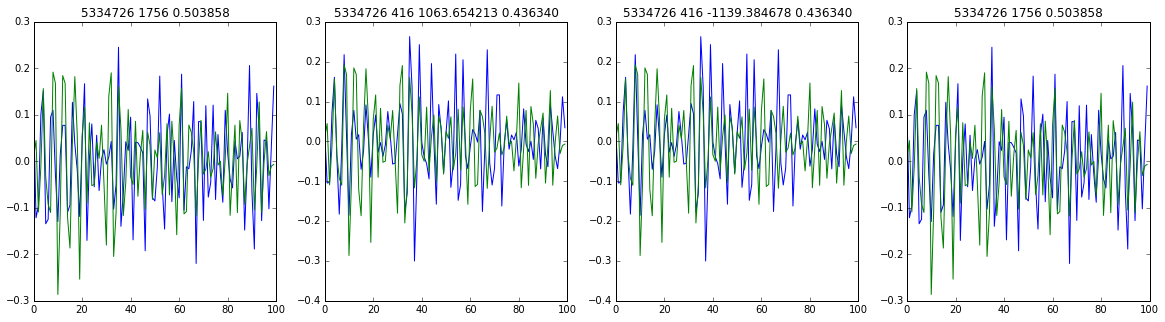

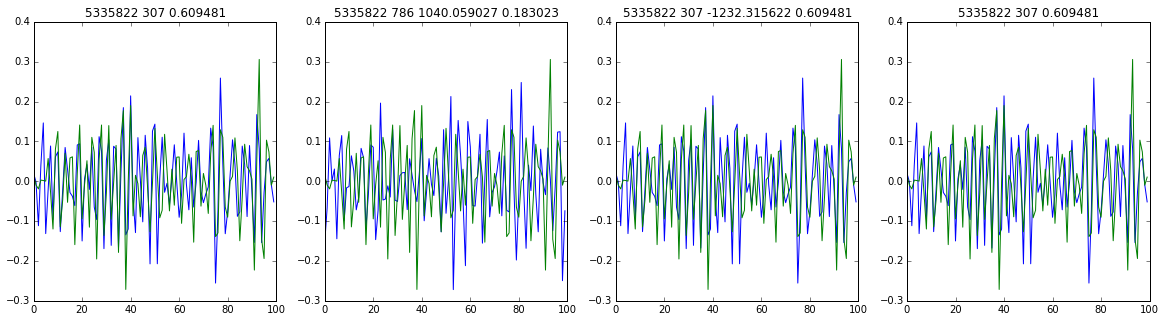

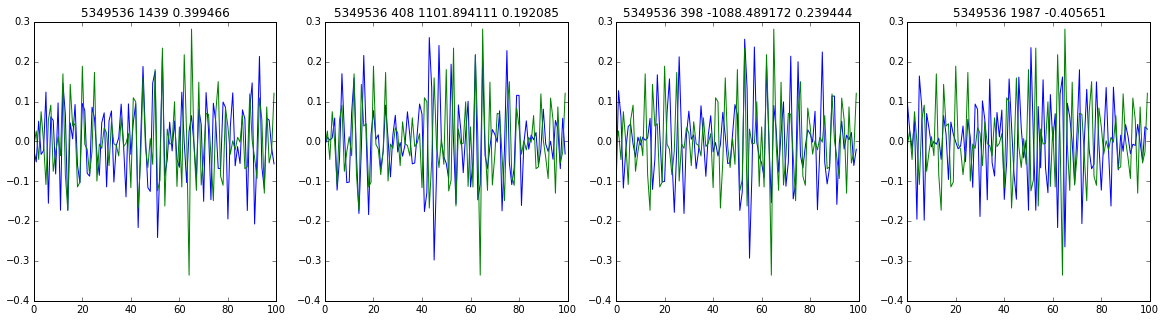

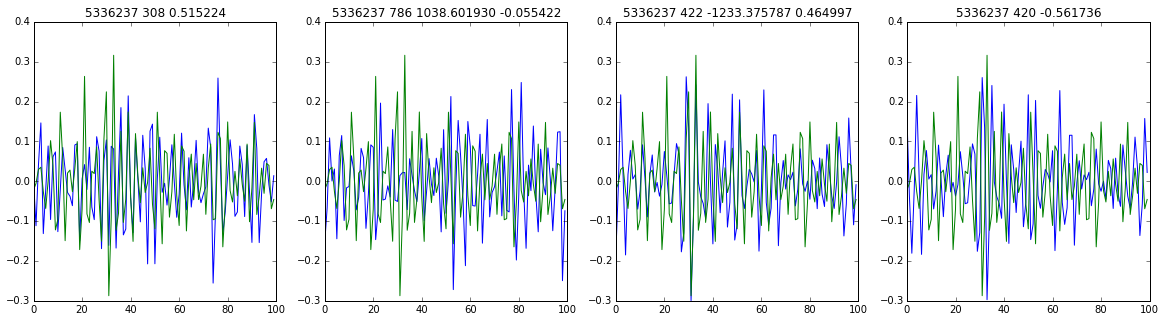

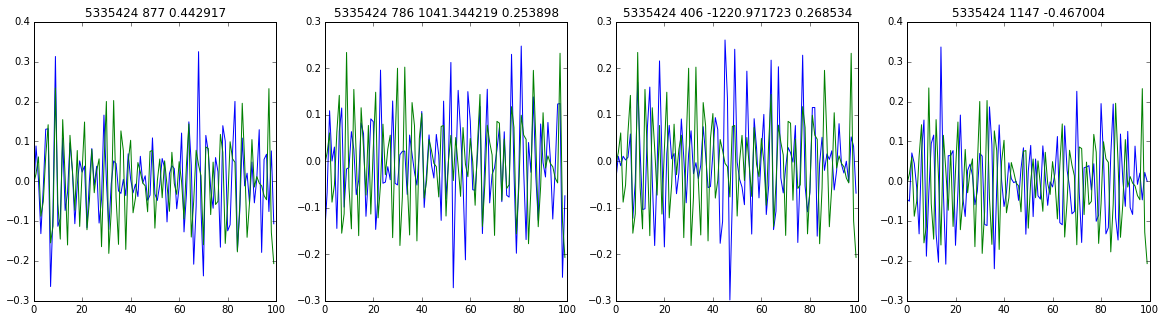

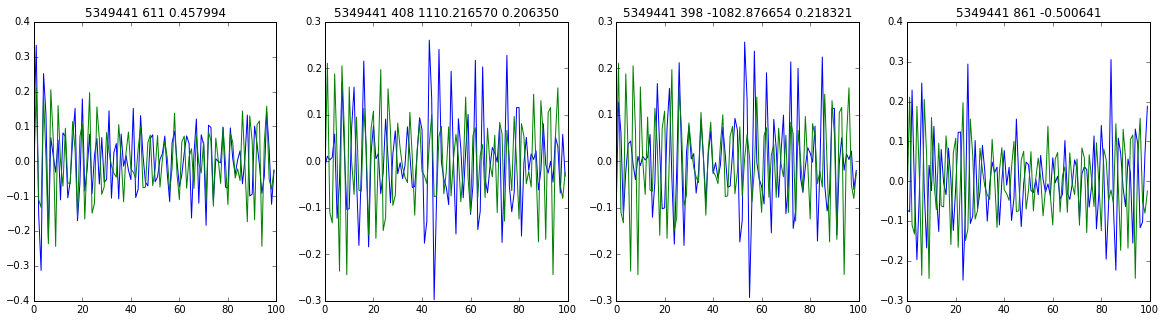

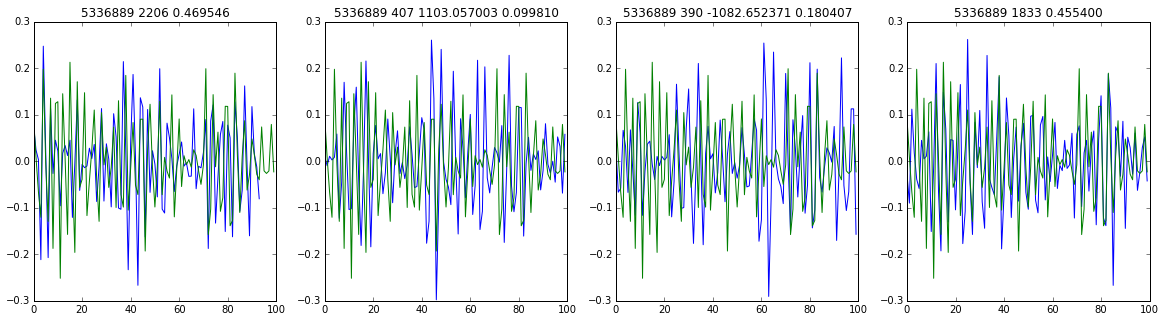

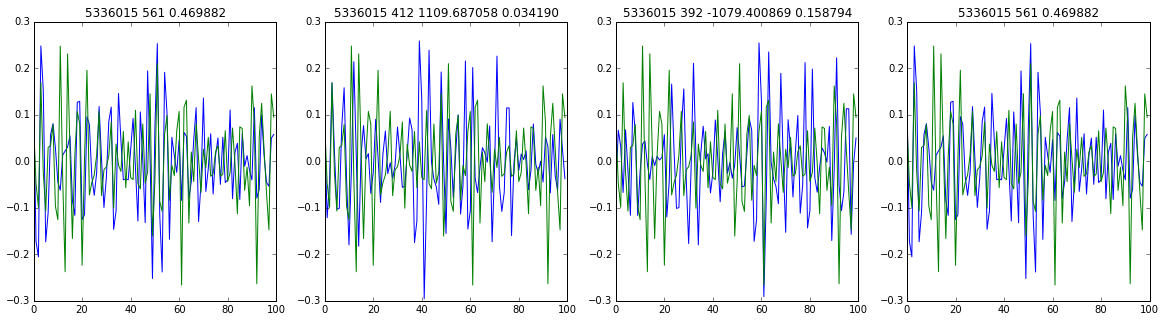

In [17]:
from sigvisa.signals.xc import my_xc
sdata = s_new.data
for (evid, c, kappa) in templates:
    xc = my_xc( c, sdata)
    lls = likelihood_windowed(sdata, c.data, kappa, sigma2_B)
    
    arb, _ = arbaseline(sdata, n)
    iidb, _ = iidbaseline(sdata, n)
    lls_ar = lls+ arb
    lls_iid = lls + iidb
    
    lls_bc = likelihood_bc(sdata, c.data, 0.5) 
    
    
    mm1 = np.argmax(xc) 
    nn1 = sdata[mm1:mm1+len(c)]
    
    mm2 = np.argmax(lls_ar[200:2000])+200
    nn2 = sdata[mm2:mm2+len(c)]
    
    mm3 = np.argmax(lls_iid[200:2000])+200
    nn3 = sdata[mm3:mm3+len(c)]
    
    mm4 = np.argmax(lls_bc[200:2000])+200
    nn4 = sdata[mm4:mm4+len(c)]
    
    f = figure(figsize=(20, 5))
    ax = f.add_subplot(141)
    ax.plot(nn1/np.linalg.norm(nn1))
    ax.plot(c/np.linalg.norm(c))
    ax.set_title("%d %d %f " % (evid, mm1, xc[mm1]))
    
    
    
    
    ax = f.add_subplot(142)
    
    ax.plot(nn2/np.linalg.norm(nn2))
    ax.plot(c/np.linalg.norm(c))
    ax.set_title("%d %d %f %f" % (evid, mm2, lls_ar[mm2], xc[mm2]))
    
    
    ax = f.add_subplot(143)
    ax.plot(nn3/np.linalg.norm(nn3))
    ax.plot(c/np.linalg.norm(c))
    ax.set_title("%d %d %f %f" % (evid, mm3, lls_iid[mm3], xc[mm3]))
    
    ax = f.add_subplot(144)
    ax.plot(nn4/np.linalg.norm(nn4))
    ax.plot(c/np.linalg.norm(c))
    ax.set_title("%d %d %f" % (evid, mm4, xc[mm4]))


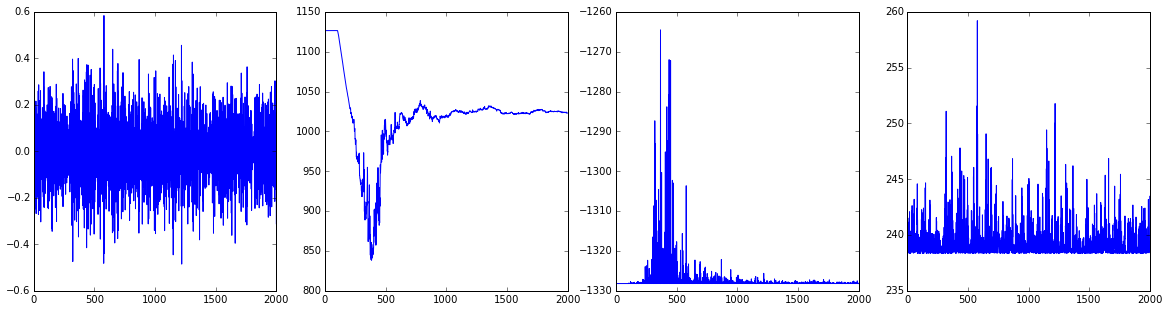

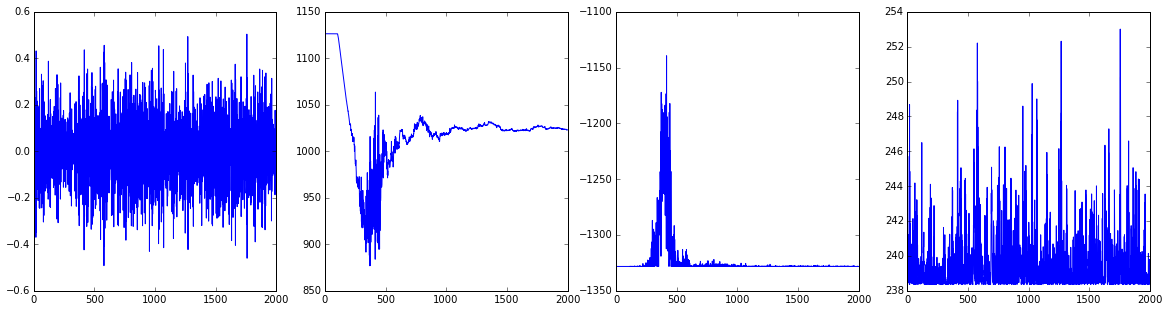

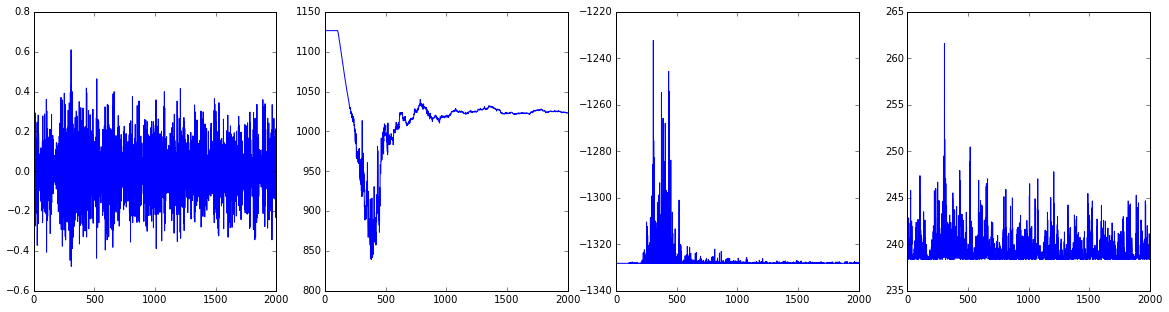

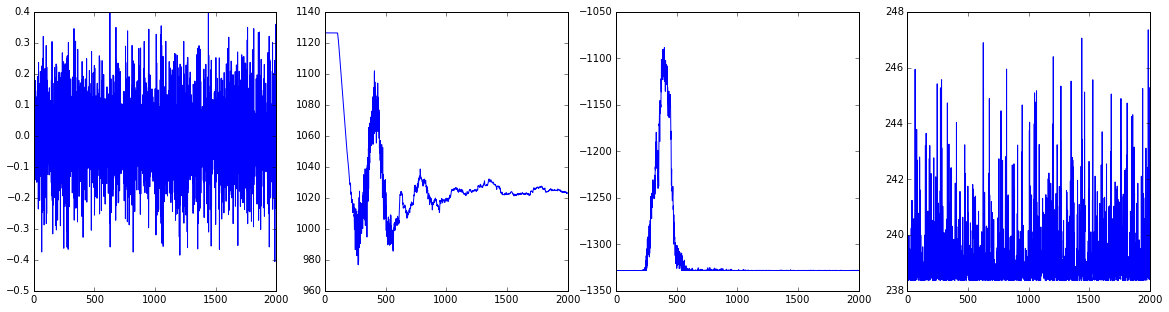

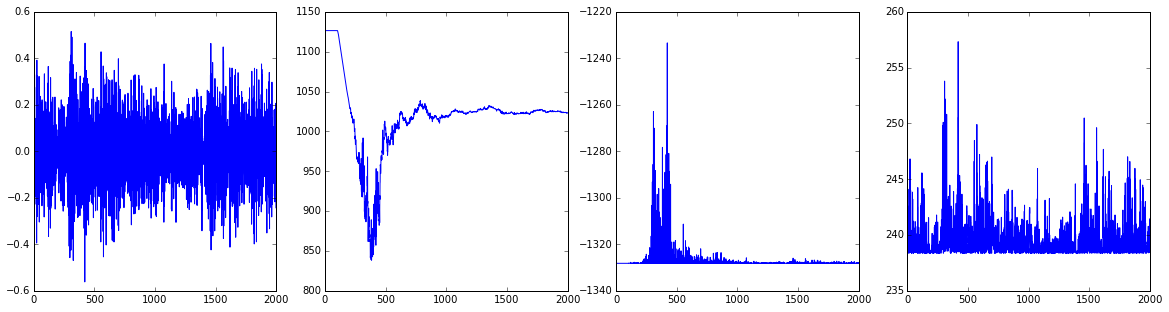

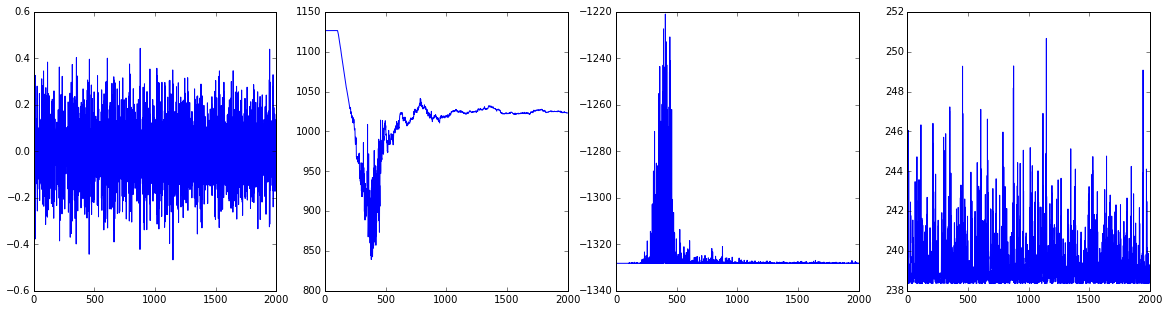

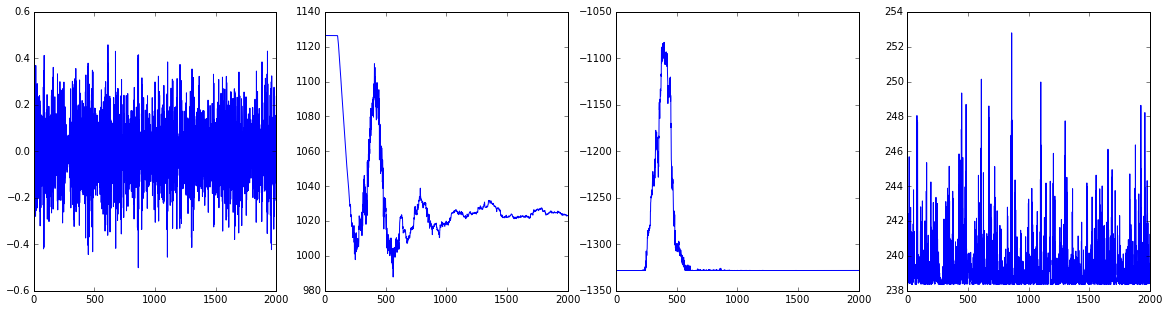

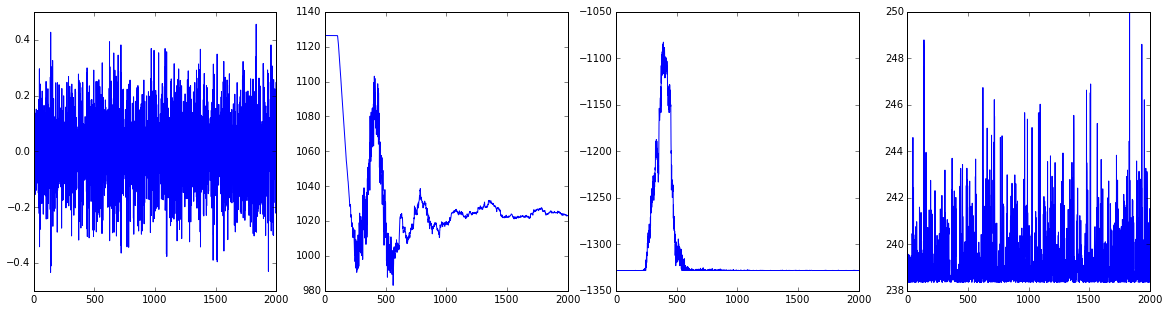

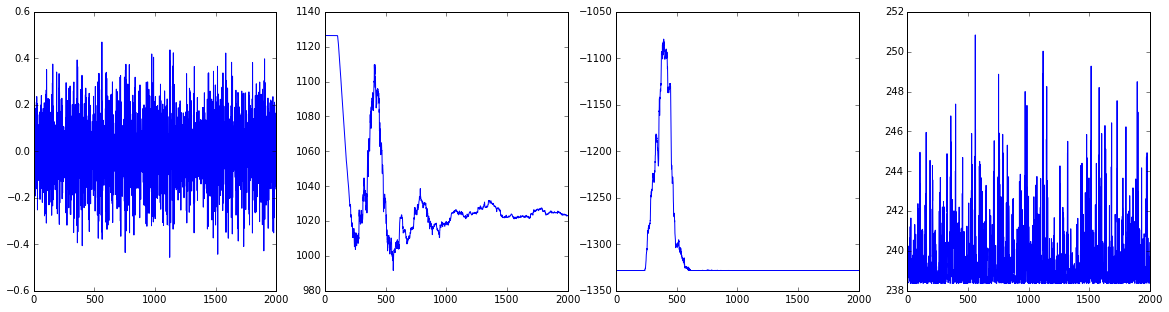

In [18]:
for (evid, c, kappa) in templates:
    xc = my_xc( c, sdata)

    lls = likelihood_windowed(sdata, c.data, kappa, sigma2_B) 
    arb, _ = arbaseline(sdata, n)
    iidb, _ = iidbaseline(sdata, n)
    lls_ar = lls + arb
    lls_iid = lls + iidb
    lls_bc = likelihood_bc(sdata, c.data, 0.5)
    
    
    f = figure(figsize=(20, 5))
    ax = f.add_subplot(141)
    ax.plot(xc[:2000])
    
    
    
    
    ax = f.add_subplot(142)
    
    ax.plot(lls_ar[:2000])
    
    
    ax = f.add_subplot(143)
    ax.plot(lls_iid[:2000])
    
    ax = f.add_subplot(144)
    ax.plot(lls_bc[:2000])


In [10]:
aux="""
double model_lik(double beta, double kappa, double sigma2_B, double norm2B, double Bc, double norm2c, int nvalid) {
    double C = beta*beta*kappa + sigma2_B;
    double d = log(6.28318530718 * C);
    return -.5 * (norm2B - 2*beta*Bc + beta*beta * norm2c) / C - .5*nvalid*d;
}

double iid_lp(blitz::Array<double,1> S, blitz::Array<int,1> mask, int k, int n, double sigma2_B) {
    double lp = 0;
    double c = -.5*log(6.28318530718 * sigma2_B);
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       lp += -.5 * (S(i)*S(i)/sigma2_B) + c;
    }
    return lp;
}

double model_lp(blitz::Array<double,1> S, blitz::Array<int,1> mask, 
                blitz::Array<double,1> c, int k, int n, 
                double kappa, double sigma2_B) {
    /*
    return the log odds of the correlation model for a latent signal c of length n, beginning at time k in S.
    That is, we return
    log(S | latent signal starts at time k) - log (S | no latent signal, everything explained as noise)
    using a maximum likelihood estimate of the scale parameter for the latent signal. 
    */
                
    double norm2B = 0;
    double Bc = 0;
    double norm2c = 0;
    int nvalid = 0;
    for(int i=k; i < k+n; ++i) {
       if (mask(i)) continue;
       norm2B += S(i)*S(i);
       Bc += S(i)*c(i-k);
       norm2c += c(i-k)*c(i-k);
       nvalid += 1;
    }    

    double aa = n*kappa*kappa; 
    double ab = kappa*Bc;
    double ac = n*kappa* sigma2_B - kappa *norm2B + sigma2_B * norm2c;
    double ad = -sigma2_B*Bc;
    
    double d0 = ab*ab - 3*aa*ac;
    double d1 = 2*ab*ab*ab-9*aa*ab*ac+27*aa*aa*ad;

    
    double _Complex inside = d1*d1 - 4*d0*d0*d0 + 0*I;
    double _Complex C = cpow((d1 + csqrt(inside))/2.0, 1/3.0);
    
    
    double _Complex u1 = (-1+sqrt(3.0)*I)/2.0;
    double _Complex u2 = (-1-sqrt(3.0)*I)/2.0;
    double _Complex u3 = 1;
    double b1 = creal(-1/(3*aa) * (ab + u1*C + d0/(u1*C)));
    double b2 = creal(-1/(3*aa) * (ab + u2*C + d0/(u2*C)));
    double b3 = creal(-1/(3*aa) * (ab + u3*C + d0/(u3*C)));
    
    
    double base_lp = iid_lp(S, mask, k, n, sigma2_B);
    
    double best_b = 0.0;
    double best_lik = 0.0; // corresponding to beta=0
    double lik = 0;
    if (b1 > 0) {
        lik = model_lik(b1, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
            printf("b1 best lik %f %f\\n", lik, best_lik);
           best_lik = lik;
           best_b = b1;
        }
    }
    if (b2 > 0) {
        lik = model_lik(b2, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
           printf("b2 best lik %f %f\\n", lik, best_lik);
           best_lik = lik;
           best_b = b2;
        }
    }
    if (b3 > 0) {
        lik = model_lik(b3, kappa, sigma2_B, norm2B, Bc, norm2c, nvalid) - base_lp;
        if (lik > best_lik) {
           printf("b3 %f best lik %f %f\\n", b3, lik, best_lik);
           best_lik = lik;
           best_b = b3;
        }
    }
    printf("%d inside %f %f %f %f best %f %f\\n", k, creal(inside), b1, b2, b3, best_b, best_lik);
    
    return best_lik;
}


"""


code="""
 
double baselp = iid_lp(S, mask, 0, N, sigma2_B);
for(int k=0; k < N-n; ++k) {    
result(k) = baselp + model_lp(S, mask, c, k, n, kappa, sigma2_B); 
}

"""

import scipy.weave as weave
from scipy.weave import converters
N = len(S)
result = np.zeros((N-50,))
mask = np.zeros((N,), dtype=np.int32)
c = K*A
kappa = R 
weave.inline(code,['S', 'mask', 'c', 'N', 'n', 'kappa', 'sigma2_B', 'result',],type_converters = converters.blitz,
             verbose=2,compiler='gcc', support_code=aux, headers=["<math.h>","<complex.h>"],)

In [14]:
j = likelihood(S, c, kappa, sigma2_B) 

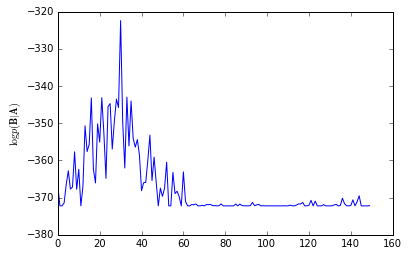

In [12]:
plot(result)
plt.ylabel("$\log p(\mathbf{B} | \mathbf{A})$")

In [40]:
plot(j)

NameError: name 'j' is not defined

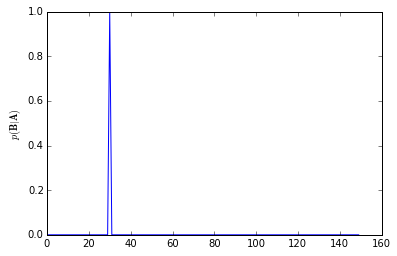

In [56]:
plot(np.exp(result-np.max(result)))
plt.ylabel("$p(\mathbf{B} | \mathbf{A})$")

In [16]:
from sigvisa.signals.xc import my_xc
r = my_xc(A, S)

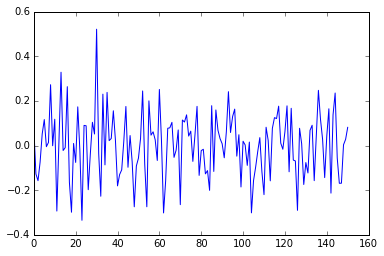

In [17]:
plot(r)

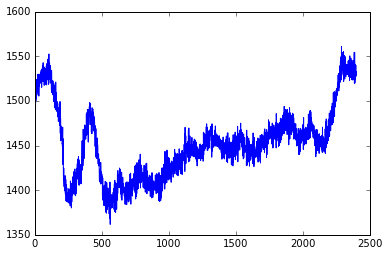

In [13]:
plot(vv[:2400] + llar)

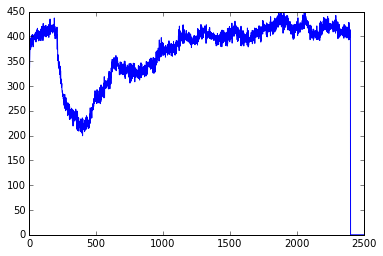

In [14]:
plot(vv)

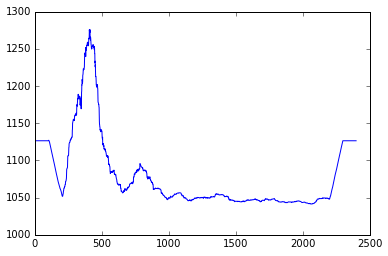

In [15]:
plot(llar)